In [1]:
import os, sys, glob, json, contextlib
import librosa
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

# deal with a known bug in sklearn that pollutes stdout: https://stackoverflow.com/questions/52596204/the-imp-module-is-deprecated
with contextlib.redirect_stderr(None):
    from sklearn import metrics
    from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 1

In [6]:
%aimport src.dataloader
%aimport train
%aimport src.model 
import src.params
from IPython.display import display, Audio

Loaded mean and invstd from: ../train_data/mean64.txt ../train_data/invstd64.txt
Loading file: 60012.wav
Loading file: 92303001.wav
Loading file: 92303002.wav
Loading file: 92303003.wav
Loading file: 92303004.wav
Loading file: 92303005.wav
Loading file: 92303006.wav
Loading file: 92303007.wav
Loading file: 92303008.wav
Loading file: 92303009.wav
Loading file: 9230300A.wav
Loading file: 9230300B.wav
Loading file: 9230300C.wav
Loading file: 9230300D.wav
Loading file: 9230300E.wav
Loading file: 9230300F.wav
Loading file: 97745001.wav
Loading file: 97745002.wav
Loading file: 97745003.wav
Loading file: 97745004.wav
Loading file: 97745005.wav
Loading file: 97745006.wav
Loading file: 97753001.wav
Loading file: 97753002.wav
Loading file: 97753003.wav
Loading file: 97753004.wav
Loading file: 97753005.wav
Loading file: 97753006.wav
Loading file: 97753007.wav
Loading file: 97753008.wav
Loading file: 97753009.wav
Loading file: 9775300A.wav
Loading file: 9775300B.wav
Loading file: 9775300C.wav
Load

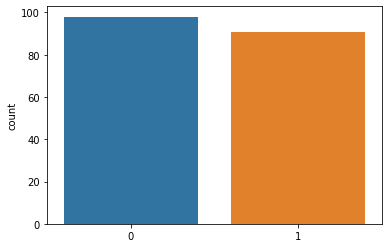

In [8]:
dev_dataset = src.dataloader.AudioFileDataset(
    "../train_data/wav","../train_data/dev.tsv",mean="../train_data/mean64.txt",invstd="../train_data/invstd64.txt"
)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, drop_last=False)
print("Total dataset size:",len(dev_dataset))
labels = [l[2] for l in dev_dataset.windows]
sns.countplot(labels)

In [12]:
net, curr_epoch = src.model.get_model_or_checkpoint("AudioSet_fc_all","../runs/AudioSet_fc_all_run3/",1,epoch=8)
net = net.eval()
preds = []
targets = []
for i, (data,target) in enumerate(dev_dataloader):
    data, target = data.unsqueeze(1).float().cuda(), target.cuda() 
    pred, _ = net(data)
    preds.append(torch.argmax(pred, dim=1).cpu().item())
    targets.append(target.cpu().item())
print(metrics.classification_report(targets,preds))
print(metrics.confusion_matrix(targets,preds))

Loaded checkpoint: ../runs/AudioSet_fc_all_run3\AudioSet_fc_all_Iter_8
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        98
           1       0.94      0.73      0.82        91

   micro avg       0.85      0.85      0.85       189
   macro avg       0.87      0.84      0.84       189
weighted avg       0.86      0.85      0.84       189

[[94  4]
 [25 66]]


In [273]:
fns = [ i for i in range(len(preds)) if (preds[i]==0) and (targets[i]==1) ]
fps = [ i for i in range(len(preds)) if (preds[i]==1) and (targets[i]==0) ]
for i in fns:
    print(i,dev_dataset.windows[i][:2],dev_dataset.windows[i][-1].name)

14 (736320, 785320) 60012.wav
18 (932720, 981720) 60012.wav
19 (1027620, 1076620) 60012.wav
21 (1183920, 1232920) 60012.wav
22 (1222500, 1271500) 60012.wav
26 (1460800, 1509800) 60012.wav
32 (1859400, 1908400) 60012.wav
37 (2119760, 2168760) 60012.wav
44 (2480580, 2529580) 60012.wav
45 (2528300, 2577300) 60012.wav
48 (2717600, 2766600) 60012.wav
49 (2792700, 2841700) 60012.wav
50 (2823660, 2872660) 60012.wav
55 (3091120, 3140120) 60012.wav
57 (3216980, 3265980) 60012.wav
58 (3255540, 3304540) 60012.wav
62 (3471219, 3520219) 60012.wav
67 (3742240, 3791240) 60012.wav
78 (4305040, 4354040) 60012.wav
79 (4394360, 4443360) 60012.wav
80 (4486220, 4535220) 60012.wav
83 (4639780, 4688780) 60012.wav
84 (4680180, 4729180) 60012.wav
86 (4814280, 4863280) 60012.wav
87 (4904040, 4953040) 60012.wav
88 (4957380, 5006380) 60012.wav


In [271]:
idx = np.random.choice(fns)
_, label = dev_dataset[idx]
print("Idx:",idx,"out of total",len(fns),"Label",label)
dev_dataset.get_mode = 'audio'
sample, label = dev_dataset[idx]
Audio(sample,rate=dev_dataset.sr)

Idx: 26 out of total 26 Label 1


(96, 64)


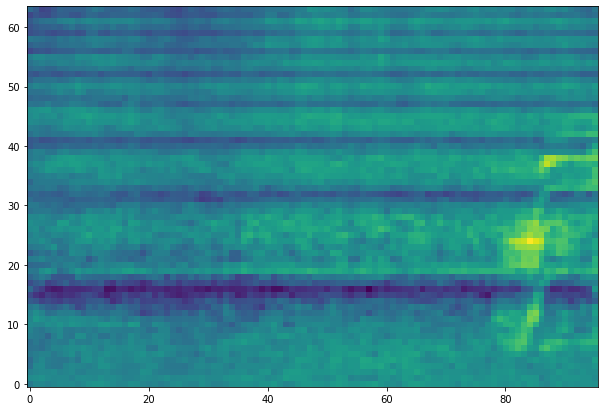

In [272]:
dev_dataset.get_mode = 'mel_spec'
mel_spec, label = dev_dataset[idx]
print(mel_spec.shape)
# plot the spectrogram
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(mel_spec.T,origin='lower')

## Explore Audioset model embeddings

In [269]:
net, curr_epoch = model.get_model_or_checkpoint("AudioSet_fc_all","../runs/AudioSet_fc_all_run3/",1,epoch12)
net = net.eval()
embeds = np.zeros((len(dev_dataloader),128))
targets = np.zeros(len(dev_dataloader))
for i, (data,target) in enumerate(dev_dataloader):
    x = data.unsqueeze(1).float()
    embeds[i,:] = net(x)[1].squeeze().detach().cpu().numpy()
    targets[i] = target

Loaded checkpoint: ../runs/AudioSet_fc_all_run3\AudioSet_fc_all_Iter_12


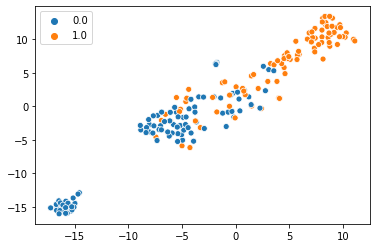

In [270]:
embeds_tsne = TSNE(n_components=2).fit_transform(embeds)
sns.scatterplot(embeds_tsne[:,0],embeds_tsne[:,1],hue=targets)